# Time Series Mumbai Temperature

https://www.kaggle.com/datasets/vikramamin/arima-time-series-mumbai-temperature/data

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pandas import to_datetime
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import pmdarima as pm
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

In [3]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

## Dataset

Dataset consists of 1781 rows and 10 columns and covers the period from 1st Jan’16 to 15th Nov’20.

    datetime: date
    temp: temperature
    dew: dew
    humidity: humidity
    sealevelpress: sea level pressure
    winddir: wind direction
    solarradition: solar radiation
    windspeed: wind speed in km/hr
    preciprob: probability of precipitation
    preciptype: type of precipitation

In [4]:
raw = pd.read_csv('data/rainfall.csv')

raw.head()

,datetime,temp,dew,humidity,sealevelpressure,winddir,solarradiation,windspeed,precipprob,preciptype
0,01-01-2016,28.4,11.9,37.8,1016.4,147.5,216.1,16.6,0,0
1,02-01-2016,26.8,13.0,44.8,1017.2,110.3,215.7,16.6,0,0
2,03-01-2016,25.5,14.6,52.8,1015.7,145.3,221.1,18.4,0,0
3,04-01-2016,26.4,13.1,46.6,1015.3,126.9,216.2,16.6,0,0
4,05-01-2016,27.1,13.5,44.9,1014.4,125.5,208.1,16.6,0,0


In [5]:
# Convert 'datetime' to datetime type using day-first format
raw['datetime'] = pd.to_datetime(raw['datetime'], dayfirst=True)

# Set as datetime index
raw.set_index('datetime', inplace=True)                  

raw.head()

,temp,dew,humidity,sealevelpressure,winddir,solarradiation,windspeed,precipprob,preciptype
datetime,,,,,,,,,
2016-01-01,28.4,11.9,37.8,1016.4,147.5,216.1,16.6,0,0
2016-01-02,26.8,13.0,44.8,1017.2,110.3,215.7,16.6,0,0
2016-01-03,25.5,14.6,52.8,1015.7,145.3,221.1,18.4,0,0
2016-01-04,26.4,13.1,46.6,1015.3,126.9,216.2,16.6,0,0
2016-01-05,27.1,13.5,44.9,1014.4,125.5,208.1,16.6,0,0


In [6]:
raw.tail()

,temp,dew,humidity,sealevelpressure,winddir,solarradiation,windspeed,precipprob,preciptype
datetime,,,,,,,,,
2020-11-11,27.4,12.2,41.5,1011.8,108.3,220.4,17.2,0,0
2020-11-12,28.0,13.0,40.9,1012.6,148.4,225.1,16.6,0,0
2020-11-13,28.4,18.7,56.9,1011.9,131.8,223.4,18.4,0,0
2020-11-14,29.5,20.9,61.3,1010.2,154.2,232.7,19.3,0,0
2020-11-15,29.7,22.3,65.4,1010.7,150.5,225.9,17.1,0,0


In [7]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1781 entries, 2016-01-01 to 2020-11-15
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              1781 non-null   float64
 1   dew               1781 non-null   float64
 2   humidity          1781 non-null   float64
 3   sealevelpressure  1781 non-null   float64
 4   winddir           1781 non-null   float64
 5   solarradiation    1781 non-null   float64
 6   windspeed         1781 non-null   float64
 7   precipprob        1781 non-null   int64  
 8   preciptype        1781 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 139.1 KB


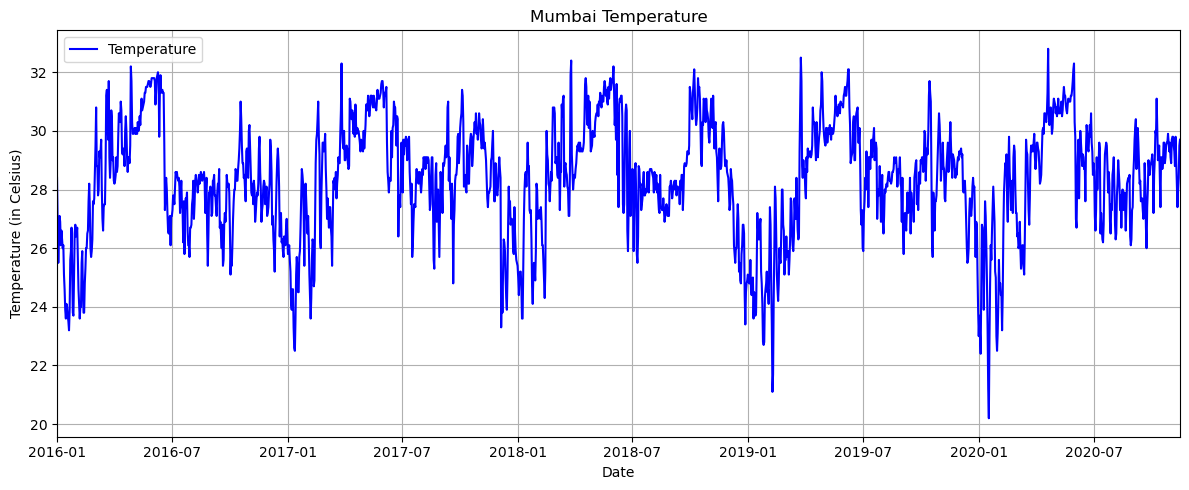

In [8]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 5))                                      

plt.plot(raw.index, raw['temp'], label='Temperature', color='blue')     

plt.title('Mumbai Temperature')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (in Celsius)')  
plt.xlim(pd.to_datetime('2016-01-01'), pd.to_datetime('2020-11-15'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

In [9]:
# Group by month and compute mean
raw_monthly = raw.resample('MS').mean()  

raw_monthly.head()

,temp,dew,humidity,sealevelpressure,winddir,solarradiation,windspeed,precipprob,preciptype
datetime,,,,,,,,,
2016-01-01,25.403226,13.877419,51.577419,1013.903226,155.293548,218.248387,18.051613,3.225806,0.032258
2016-02-01,25.789655,17.282759,61.948276,1013.010345,196.017241,237.920690,19.972414,3.448276,0.034483
2016-03-01,29.061290,19.796774,60.058065,1011.338710,217.822581,279.732258,20.787097,22.580645,0.225806
2016-04-01,29.640000,22.673333,67.810000,1009.056667,247.810000,301.263333,21.936667,16.666667,0.166667
2016-05-01,30.854839,25.367742,72.996774,1007.212903,245.554839,265.625806,22.816129,32.258065,0.322581


In [10]:
raw_monthly.tail()

,temp,dew,humidity,sealevelpressure,winddir,solarradiation,windspeed,precipprob,preciptype
datetime,,,,,,,,,
2020-07-01,28.006452,26.016129,89.364516,1003.348387,179.212903,197.354839,23.464516,100.000000,1.000000
2020-08-01,27.629032,25.670968,89.338710,1003.470968,228.183871,180.048387,30.080645,100.000000,1.000000
2020-09-01,28.410000,25.556667,85.086667,1005.740000,177.213333,178.316667,18.550000,96.666667,0.966667
2020-10-01,29.212903,24.958065,79.019355,1007.380645,161.767742,184.332258,17.338710,74.193548,0.741935
2020-11-01,29.046667,17.906667,53.360000,1012.140000,127.993333,220.886667,16.466667,0.000000,0.000000


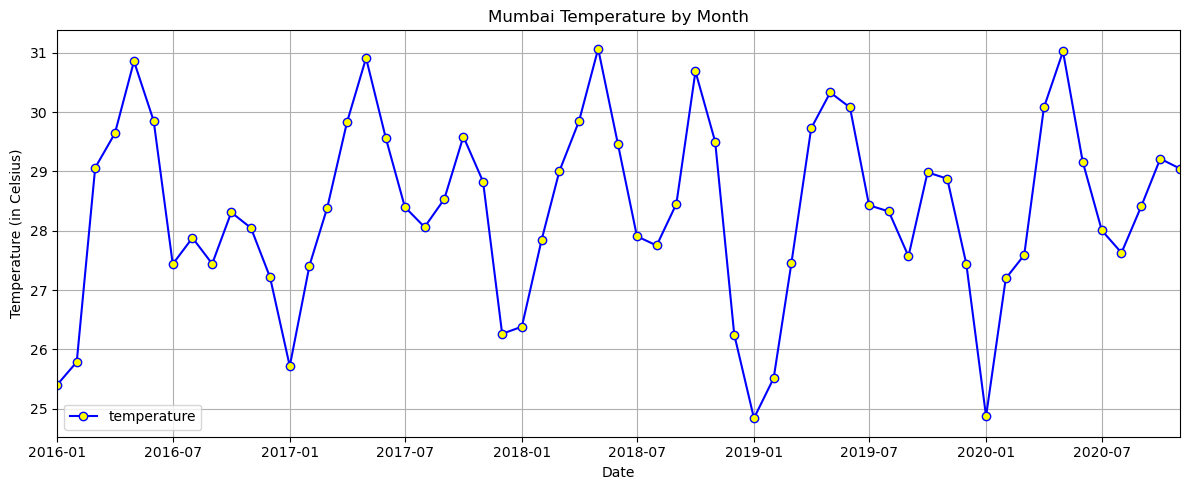

In [11]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 5))                                      

plt.plot(raw_monthly.index, raw_monthly['temp'], label='temperature', marker='o', markerfacecolor='yellow', color='blue')     

plt.title('Mumbai Temperature by Month')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (in Celsius)') 
plt.xlim(pd.to_datetime('2016-01-01'), pd.to_datetime('2020-11-01'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show()

In [12]:
# Weekly average, week ends on Sunday
raw_weekly = raw.resample('W').mean()  

raw_weekly.head()

,temp,dew,humidity,sealevelpressure,winddir,solarradiation,windspeed,precipprob,preciptype
datetime,,,,,,,,,
2016-01-03,26.900000,13.166667,45.133333,1016.433333,134.366667,217.633333,17.200000,0.000000,0.000000
2016-01-10,26.485714,14.342857,49.400000,1014.628571,130.271429,200.971429,15.714286,0.000000,0.000000
2016-01-17,24.485714,16.042857,60.985714,1012.600000,174.200000,205.000000,18.485714,14.285714,0.142857
2016-01-24,24.642857,10.000000,42.200000,1013.614286,144.985714,228.685714,20.442857,0.000000,0.000000
2016-01-31,25.357143,15.428571,56.485714,1013.685714,180.685714,238.600000,17.928571,0.000000,0.000000


In [13]:
raw_weekly.tail()

,temp,dew,humidity,sealevelpressure,winddir,solarradiation,windspeed,precipprob,preciptype
datetime,,,,,,,,,
2020-10-18,28.800000,25.542857,83.314286,1003.514286,155.785714,155.471429,15.485714,85.714286,0.857143
2020-10-25,29.314286,26.185714,83.742857,1007.628571,162.357143,131.842857,17.957143,100.000000,1.000000
2020-11-01,29.428571,21.385714,63.714286,1010.842857,150.900000,232.442857,16.742857,0.000000,0.000000
2020-11-08,29.528571,18.757143,54.500000,1012.685714,122.671429,216.971429,15.842857,0.000000,0.000000
2020-11-15,28.585714,16.928571,51.842857,1011.657143,131.085714,224.928571,17.257143,0.000000,0.000000


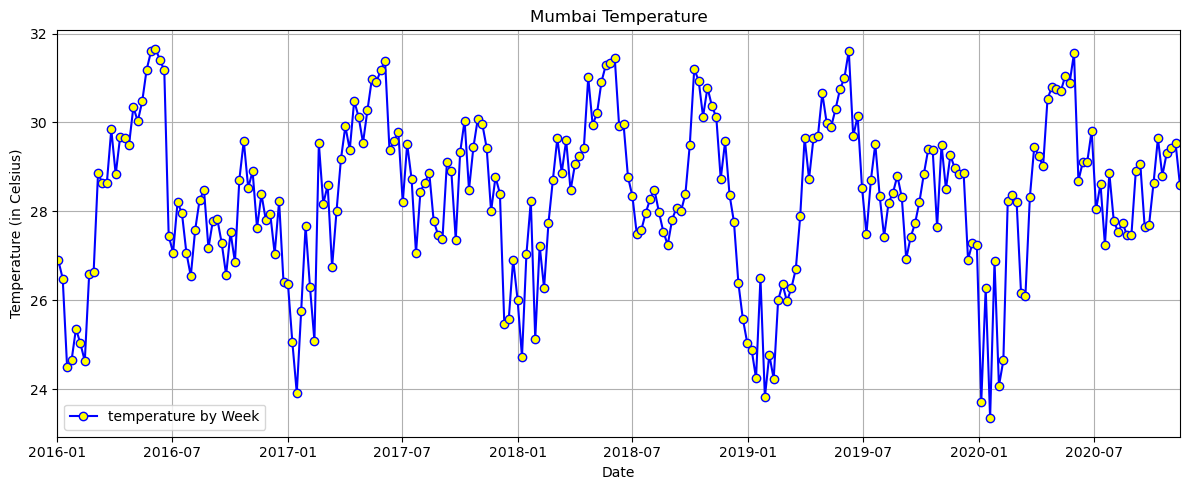

In [14]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 5))                                      

plt.plot(raw_weekly.index, raw_weekly['temp'], label='temperature by Week', marker='o', markerfacecolor='yellow', color='blue')     

plt.title('Mumbai Temperature')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (in Celsius)') 
plt.xlim(pd.to_datetime('2016-01-01'), pd.to_datetime('2020-11-15'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show()

# SARIMAX

In [15]:
# Split the data
cutoff = pd.to_datetime("2020-07-01")

train = raw_weekly[raw_weekly.index < cutoff]
test = raw_weekly[raw_weekly.index >= cutoff]

# Show results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
print(train.tail())
print()
print(test.head())

Train shape: (235, 9)
Test shape: (20, 9)

                 temp        dew   humidity  sealevelpressure     winddir  \
datetime                                                                    
2020-05-31  31.557143  25.771429  72.085714       1007.585714  272.042857   
2020-06-07  28.685714  24.628571  79.457143       1004.671429  157.900000   
2020-06-14  29.114286  25.500000  81.385714       1003.457143  189.185714   
2020-06-21  29.114286  26.242857  84.928571       1003.300000  173.614286   
2020-06-28  29.814286  26.014286  80.442857       1003.985714  174.885714   

            solarradiation  windspeed  precipprob  preciptype  
datetime                                                       
2020-05-31      233.142857  24.628571   14.285714    0.142857  
2020-06-07      148.828571  30.757143  100.000000    1.000000  
2020-06-14      214.571429  23.385714  100.000000    1.000000  
2020-06-21      165.214286  22.185714  100.000000    1.000000  
2020-06-28      214.471429  22.95

In [16]:
tem_series = train['temp']

len(tem_series)

235

In [17]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  


d = determine_nonseasonal_d(tem_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -5.1241, p-value = 0.0000

Non-seasonal differencing term (d): 0


In [18]:
def detect_seasonal(series):

    # Apply Fourier Transform
    fourier = np.fft.fft(series - np.mean(series))
    frequencies = np.fft.fftfreq(len(series))

    # Identify the most significant frequency (ignoring the 0 frequency)
    positive_freqs = frequencies[np.where(frequencies > 0)]
    significant_freq = positive_freqs[np.argmax(np.abs(fourier[1:len(positive_freqs)+1]))]

    # Calculate the seasonal period (S)
    S = int(1 / significant_freq)

    return print(f"Detected Seasonal Period: S = {S}")

detect_seasonal(tem_series)

Detected Seasonal Period: S = 26


In [19]:
def detect_top_seasonal_periods(series, top_n=5):
    import numpy as np
    import pandas as pd

    # Remove mean to center the series
    series_detrended = series - np.mean(series)

    # Apply Fourier Transform
    fourier = np.fft.fft(series_detrended)
    frequencies = np.fft.fftfreq(len(series))

    # Only keep positive frequencies (exclude zero)
    positive_mask = frequencies > 0
    positive_freqs = frequencies[positive_mask]
    magnitudes = np.abs(fourier[positive_mask])

    # Get indices of top N magnitudes
    top_indices = np.argsort(magnitudes)[-top_n:][::-1]

    # Prepare result
    top_periods = [(round(1 / positive_freqs[i], 2), magnitudes[i]) for i in top_indices]

    # Display results
    print("Top Seasonal Periods (in time units):")
    for i, (period, magnitude) in enumerate(top_periods, 1):
        print(f"{i}. Period = {period} (Frequency = {round(positive_freqs[top_indices[i-1]], 5)}), Magnitude = {round(magnitude, 2)}")


detect_top_seasonal_periods(tem_series, top_n=10)

Top Seasonal Periods (in time units):
1. Period = 26.11 (Frequency = 0.0383), Magnitude = 203.33
2. Period = 58.75 (Frequency = 0.01702), Magnitude = 111.66
3. Period = 47.0 (Frequency = 0.02128), Magnitude = 82.28
4. Period = 39.17 (Frequency = 0.02553), Magnitude = 65.77
5. Period = 29.38 (Frequency = 0.03404), Magnitude = 42.81
6. Period = 13.06 (Frequency = 0.0766), Magnitude = 42.65
7. Period = 33.57 (Frequency = 0.02979), Magnitude = 35.82
8. Period = 4.7 (Frequency = 0.21277), Magnitude = 31.17
9. Period = 16.79 (Frequency = 0.05957), Magnitude = 30.28
10. Period = 12.37 (Frequency = 0.08085), Magnitude = 28.0


In [20]:
def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D = max(nsdiffs(series, m=m, test='ch'),
            nsdiffs(series, m=m, test='ocsb'))

    return D

for m in  [4, 5, 26, 52]:

    D = determine_seasonal_D(tem_series, m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 4: 0
Seasonal differencing term (D) for 5: 0
Seasonal differencing term (D) for 26: 0
Seasonal differencing term (D) for 52: 0


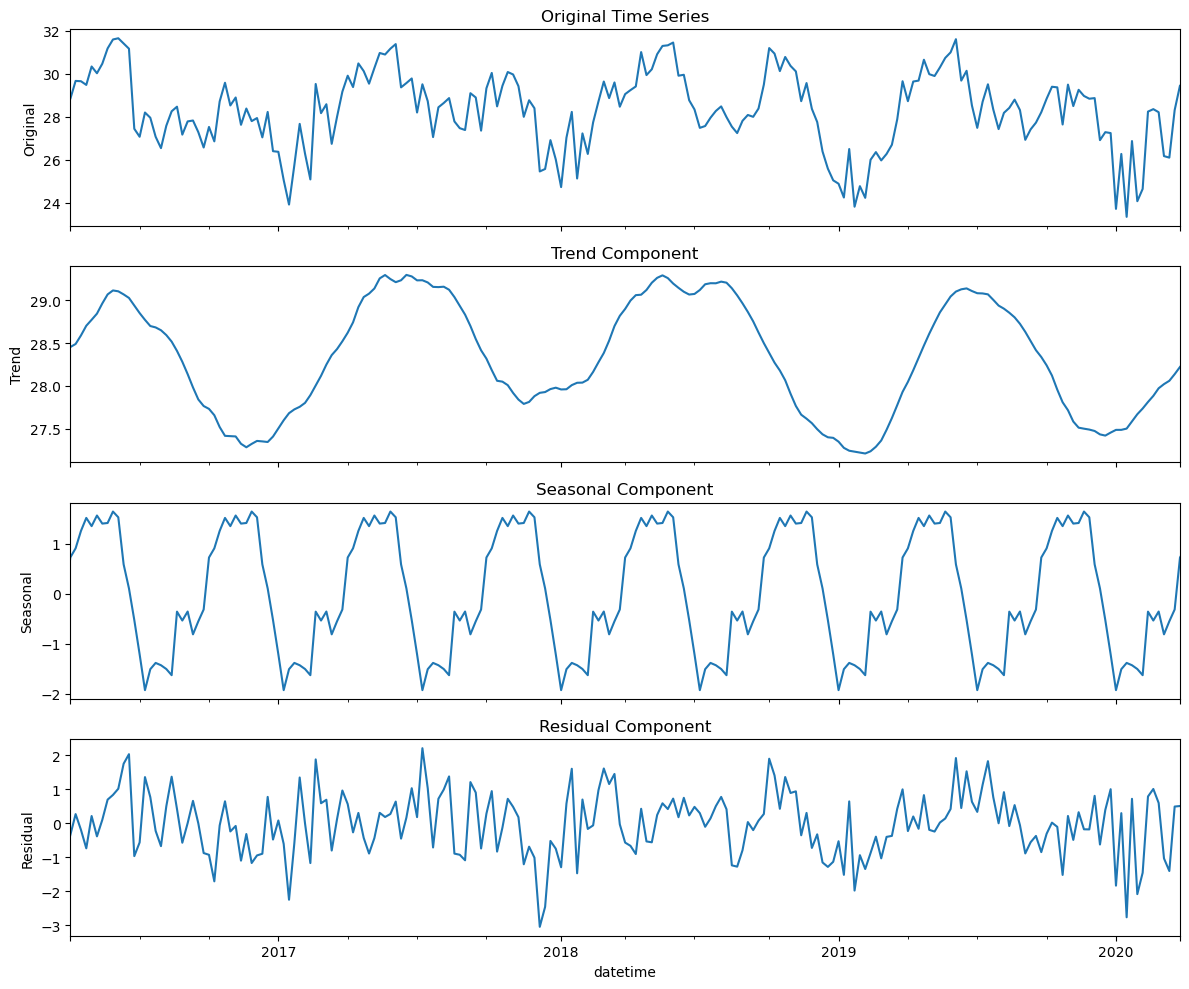

In [21]:
result = seasonal_decompose(tem_series, model='aditive', period=26)

trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()


# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

result.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('Original')

trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

residual.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

# SARIMAX

In [22]:
def best_auto_arima(series, d=0, D=0, S=12):

    # Perform a full search over the same grid as your manual SARIMAX model
    auto_model = pm.auto_arima(
        series,                     # The time series data
        seasonal=True,              # Enable seasonal component
        m=S,                        # Seasonal period
        d=d,                        # Set differencing 
        D=D,                        # Set seasonal differencing
        start_p=0, max_p=3,         # p 
        start_q=0, max_q=3,         # q 
        start_P=0, max_P=3,         # P 
        start_Q=0, max_Q=3,         # Q 
        stepwise=False,             # Disable stepwise search (enable full grid search)
        trace=False,                # Print model search progress
        error_action='ignore',      # Ignore errors and continue
        suppress_warnings=True,     # Suppress convergence warnings
        information_criterion='aic' # Use AIC to choose the best model
    )

    # Print the best model found
    print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

best_auto_arima(tem_series, d=0, D=0, S=26)

Best model: SARIMA(1, 0, 1)(2, 0, 0, 26)


In [23]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]       # Generate Cartesian product of input lists
    return combo                                         # Return the list of combinations


def find_best(series, d=0, D=0, S=12):

    P_ns, Q_ns = [0, 1, 2, 3], [0, 1, 2, 3]              # Define search ranges for non-seasonal parameters (p, q)
    P_s, Q_s = [0, 1, 2, 3], [0, 1, 2, 3]                # Define search ranges for seasonal parameters (P, Q)


    total = len(P_ns) * len(Q_ns) * len(P_s) * len(Q_s)
    print(f'Total number of models: {total}')

    vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

    score = {}                                           # Dictionary to store model evaluation metrics

    for i, (p, d, q, P, D, Q) in enumerate(vals):        # Iterate over all parameter combinations
    
        if i % 15 == 0:                                  # Print progress every 15 models
            print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

        m = SARIMAX(series,                              # Define SARIMA model with current parameter set
                    order=(p,d,q), 
                    seasonal_order=(P, D, Q, S),   
                    enforce_stationarity=False)          # Allow non-stationary models for broader search

        res = m.fit(disp=0, low_memory=True)             # Fit the model silently

        score[i] = {                                     # Store model results and evaluation metrics
            'non-seasonal order': (p, d, q),      
            'seasonal order': (P, D, Q),
            'AIC': res.aic,                              # Akaike Information Criterion
        }
        
    print("\nBest models by AIC:")
    best_models = pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()
    print(best_models)


find_best(series=tem_series, d=0, D=0, S=26)

Total number of models: 256
Running model #0 using SARIMA(0,0,0)(0,0,0,26)
Running model #15 using SARIMA(0,0,0)(3,0,3,26)
Running model #30 using SARIMA(0,0,1)(3,0,2,26)
Running model #45 using SARIMA(0,0,2)(3,0,1,26)
Running model #60 using SARIMA(0,0,3)(3,0,0,26)
Running model #75 using SARIMA(1,0,0)(2,0,3,26)
Running model #90 using SARIMA(1,0,1)(2,0,2,26)
Running model #105 using SARIMA(1,0,2)(2,0,1,26)
Running model #120 using SARIMA(1,0,3)(2,0,0,26)
Running model #135 using SARIMA(2,0,0)(1,0,3,26)
Running model #150 using SARIMA(2,0,1)(1,0,2,26)
Running model #165 using SARIMA(2,0,2)(1,0,1,26)
Running model #180 using SARIMA(2,0,3)(1,0,0,26)
Running model #195 using SARIMA(3,0,0)(0,0,3,26)
Running model #210 using SARIMA(3,0,1)(0,0,2,26)
Running model #225 using SARIMA(3,0,2)(0,0,1,26)
Running model #240 using SARIMA(3,0,3)(0,0,0,26)
Running model #255 using SARIMA(3,0,3)(3,0,3,26)

Best models by AIC:
   index non-seasonal order seasonal order         AIC
0    127          (1, 

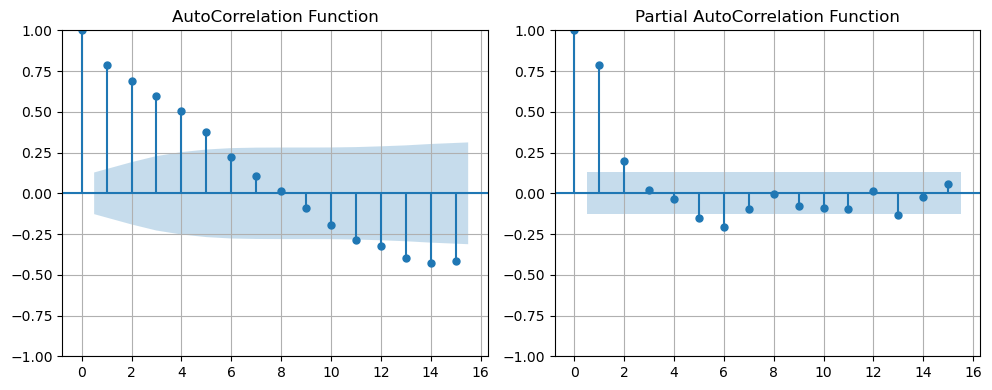

In [24]:
def acf_and_pacf(series, lagsn=15):

    # Create a 1x2 grid for subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

    # Plot AutoCorrelation Function
    plot_acf(series, ax=axes[0], lags=lagsn)
    axes[0].set_title("AutoCorrelation Function", fontsize=12)
    axes[0].grid(True)

    # Plot Partial Autocorrelation Function
    plot_pacf(series, ax=axes[1], lags=lagsn)
    axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


acf_and_pacf(tem_series, lagsn=15)

In [25]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_103 = SARIMAX(tem_series,                     # Time series data
                    order=(1, 0, 3),                # Non-seasonal order (p,d,q)
                    seasonal_order=(3, 0, 3, 26),   # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_103 = model_103.fit()

# Display summary of the model
print(model_fit_103.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               temp   No. Observations:                  235
Model:             SARIMAX(1, 0, 3)x(3, 0, 3, 26)   Log Likelihood                -226.580
Date:                            Thu, 22 May 2025   AIC                            475.160
Time:                                    13:12:53   BIC                            508.494
Sample:                                01-03-2016   HQIC                           488.701
                                     - 06-28-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8500      0.077     11.039      0.000       0.699       1.001
ma.L1         -0.5999      0.102   

In [26]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_103)

ma.L2 coefficient: 0.1156
ma.L2 95% CI: (-0.0712, 0.3024)
ma.L2 p-value: 0.2250
ma.L2 is statistically IRRELEVANT in the model.

ma.L3 coefficient: 0.0441
ma.L3 95% CI: (-0.1215, 0.2097)
ma.L3 p-value: 0.6020
ma.L3 is statistically IRRELEVANT in the model.

ar.S.L78 coefficient: 0.2174
ar.S.L78 95% CI: (-0.0177, 0.4525)
ar.S.L78 p-value: 0.0699
ar.S.L78 is statistically IRRELEVANT in the model.

ma.S.L26 coefficient: -0.4070
ma.S.L26 95% CI: (-1.6325, 0.8185)
ma.S.L26 p-value: 0.5151
ma.S.L26 is statistically IRRELEVANT in the model.

ma.S.L52 coefficient: -0.0920
ma.S.L52 95% CI: (-0.8805, 0.6965)
ma.S.L52 p-value: 0.8191
ma.S.L52 is statistically IRRELEVANT in the model.

ma.S.L78 coefficient: -0.4146
ma.S.L78 95% CI: (-1.1561, 0.3269)
ma.S.L78 p-value: 0.2732
ma.S.L78 is statistically IRRELEVANT in the model.



In [27]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_101 = SARIMAX(tem_series,                     # Time series data
                    order=(1, 0, 1),                # Non-seasonal order (p,d,q)
                    seasonal_order=(2, 0, 0, 26),   # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_101 = model_101.fit()

# Display summary of the model
print(model_fit_101.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                temp   No. Observations:                  235
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 26)   Log Likelihood                -283.108
Date:                             Thu, 22 May 2025   AIC                            576.216
Time:                                     13:12:54   BIC                            592.236
Sample:                                 01-03-2016   HQIC                           582.711
                                      - 06-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8587      0.065     13.267      0.000       0.732       0.986
ma.L1         -0.5533      

In [28]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_101)

All variables are statistically relevant.


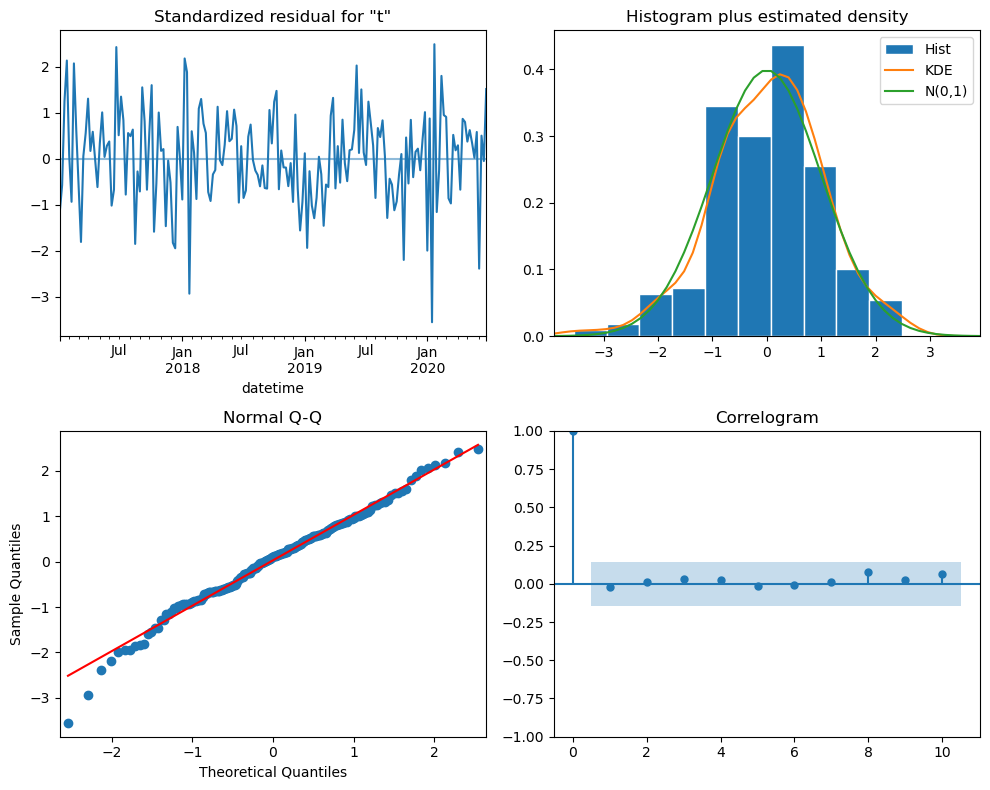

In [29]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_101.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [30]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_101.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,20.006387,7.718391e-06
2,32.901012,7.171931e-08
3,49.574497,9.842685e-11
4,64.379739,3.476345e-13
5,79.262416,1.197116e-15
6,92.610989,8.684932e-18
7,108.672556,1.730894e-20
8,123.842285,5.327955e-23
9,144.397592,1.273328e-26
10,159.366671,4.378224e-29


In [31]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 0.9471
Conclusion: Evidence of positive autocorrelation.


In [32]:
# Forecast the next Time points
forecast_S = model_fit_101.get_forecast(steps=test.shape[0])

# Extract predicted mean and confidence intervals
forecast_mean_S = forecast_S.predicted_mean
conf_int_S = forecast_S.conf_int()        

# Assign forecasts to the test DataFrame
test['Forecast S'] = forecast_mean_S.values                 # Forecast mean

test['Error S'] = test['Forecast S'] - test['temp']

test['Lower 95% CI S'] = conf_int_S.iloc[:, 0].values       # Lower bound
test['Upper 95% CI S'] = conf_int_S.iloc[:, 1].values       # Upper bound

# Show the updated test DataFrame
test.head()

,temp,dew,humidity,sealevelpressure,winddir,solarradiation,windspeed,precipprob,preciptype,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S
datetime,,,,,,,,,,,,,
2020-07-05,28.042857,26.000000,89.057143,1002.085714,197.914286,165.342857,24.942857,100.0,1.0,26.710386,-1.332471,24.465796,28.954976
2020-07-12,28.614286,26.357143,87.900000,1002.628571,204.242857,229.514286,27.457143,100.0,1.0,28.315304,-0.298982,25.968397,30.662212
2020-07-19,27.242857,26.014286,93.271429,1001.971429,169.157143,192.414286,23.200000,100.0,1.0,27.774671,0.531814,25.355089,30.194254
2020-07-26,28.857143,25.842857,84.257143,1005.257143,168.214286,186.742857,19.400000,100.0,1.0,28.171478,-0.685665,25.699676,30.643280
2020-08-02,27.785714,25.814286,89.471429,1004.400000,157.842857,194.842857,21.871429,100.0,1.0,26.559480,-1.226234,24.049870,29.069091


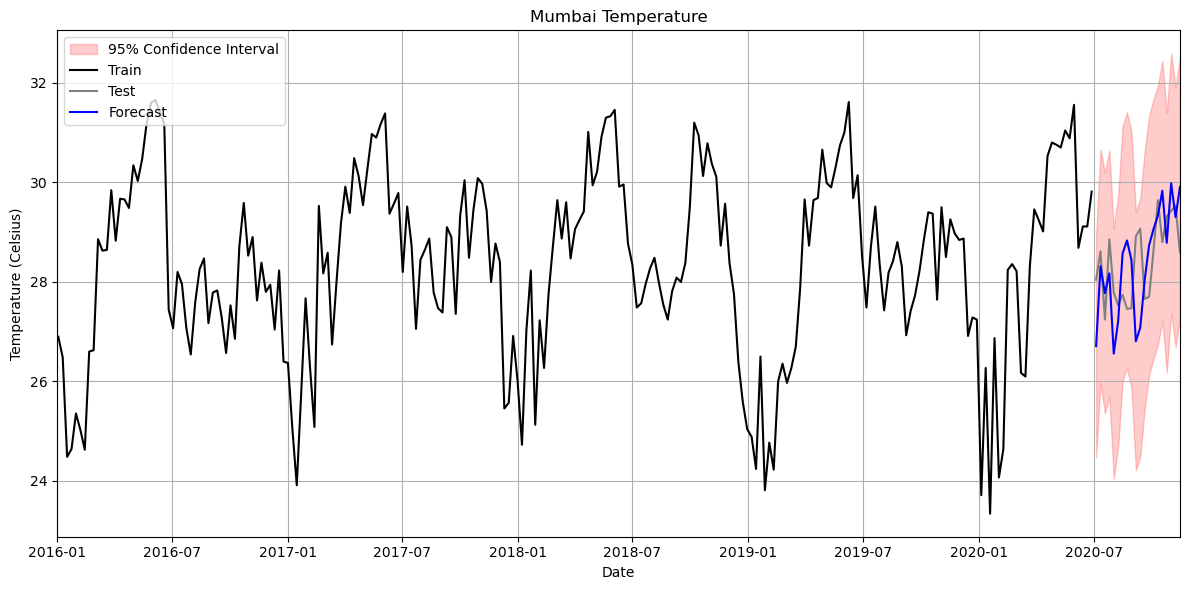

In [33]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_S.iloc[:, 0],     # Lower bound
                 conf_int_S.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['temp'], label='Train', color='black')           # Train
plt.plot(test.index, test['temp'], label='Test', color='gray')               # Test
plt.plot(test.index, test['Forecast S'], label='Forecast', color='blue')     # Forecast

plt.title('Mumbai Temperature')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (Celsius)')
plt.xlim(pd.to_datetime('2016-01-01'), pd.to_datetime('2020-11-15'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show();

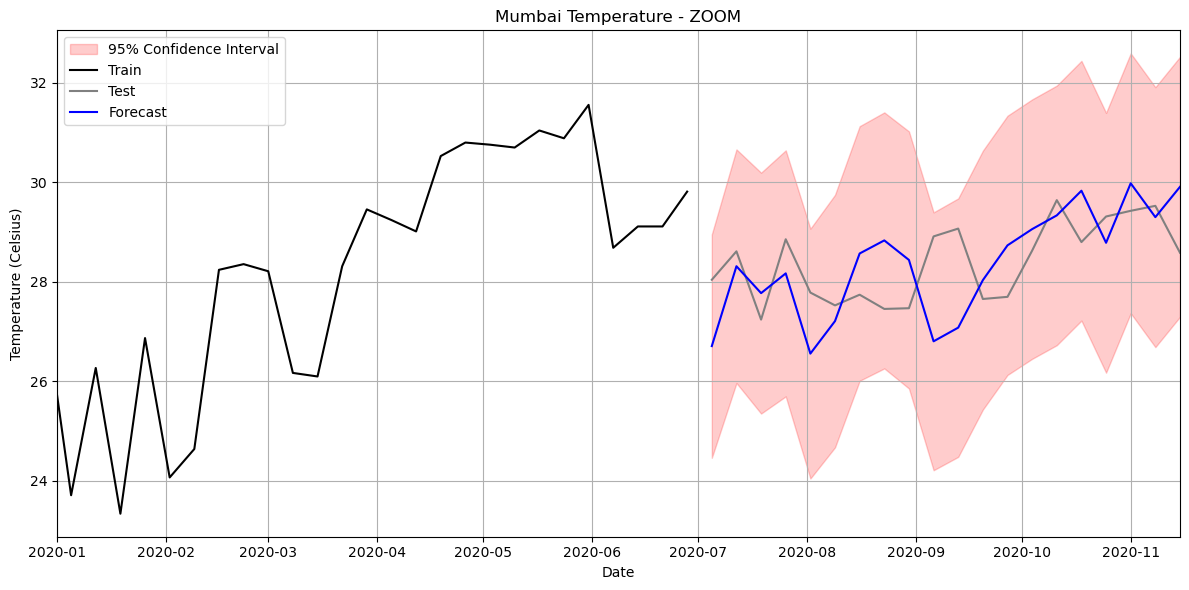

In [34]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_S.iloc[:, 0],     # Lower bound
                 conf_int_S.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['temp'], label='Train', color='black')           # Train
plt.plot(test.index, test['temp'], label='Test', color='gray')               # Test
plt.plot(test.index, test['Forecast S'], label='Forecast', color='blue')     # Forecast

plt.title('Mumbai Temperature - ZOOM')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (Celsius)')
plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2020-11-15'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show();

# SARIMAX Model with Exogenous Variables

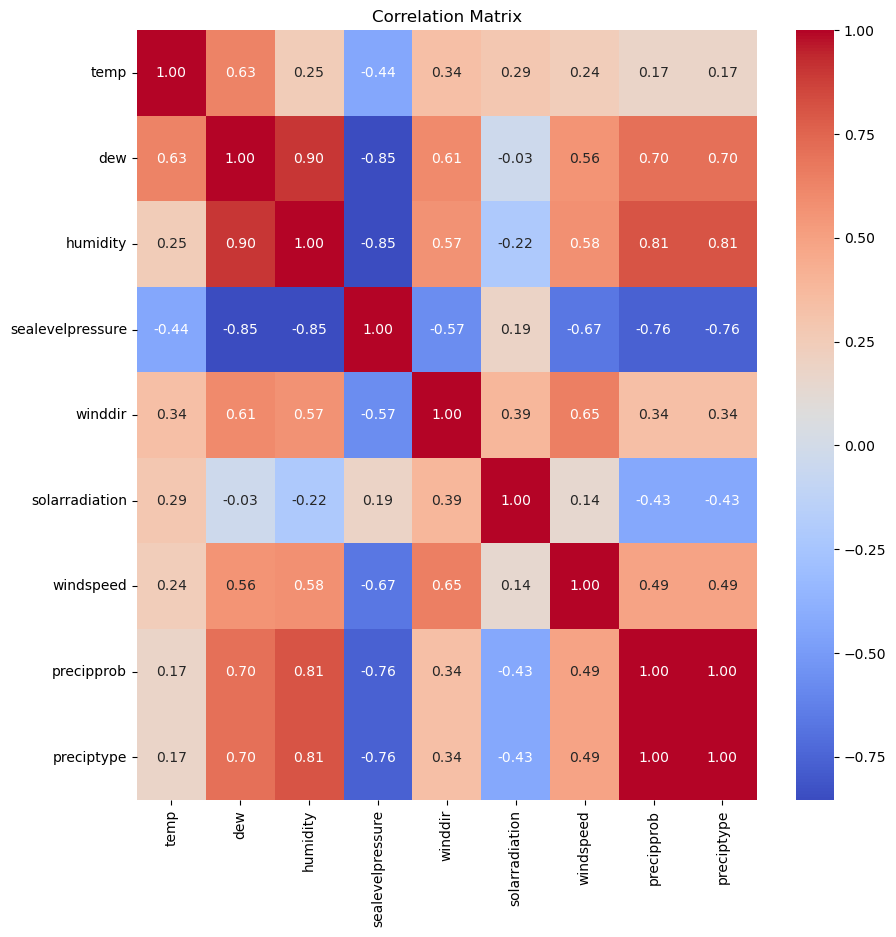

In [35]:
# Compute correlation matrix
c_matrix = train.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(c_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [36]:
# Identify columns where the first row value is >= 0.4 or <= -0.4
selected_columns = c_matrix.columns[np.logical_or(c_matrix.iloc[0] >= 0.40, 
                                                  c_matrix.iloc[0] <= -0.40)]

# Convert to list and remove target series
filtered_columns = [col for col in selected_columns if col != 'temp']

# Show the result
print(filtered_columns)

['dew', 'sealevelpressure']


In [37]:
# Create candidates dataframe
candidates = train[['dew', 'sealevelpressure']]

# Compute correlation matrix
corr_candidates = candidates.corr()

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = corr_candidates.columns
vif_data["VIF"] = [round(variance_inflation_factor(corr_candidates.values, i), 2) for i in range(len(corr_candidates.columns))]

# Define VIF interpretation rules
conditions = [
    (vif_data["VIF"] < 5),
    (vif_data["VIF"] >= 5) & (vif_data["VIF"] <= 10),
    (vif_data["VIF"] > 10)
]
choices = [
    "Not Multicollinearity",
    "Moderate Multicollinearity",
    "High Multicollinearity"
]

# Add interpretation column
vif_data["Interpretation"] = np.select(conditions, choices, default="Undefined")

# Make 'Feature' as Index
vif_data.set_index('Feature', inplace=True)

# Display VIF results
print(vif_data)
print()

# Compute and display correlation matrix
corr = corr_candidates.corr().round(2)
print(f'Correlation:\n{corr}')

                    VIF          Interpretation
Feature                                        
dew               41.13  High Multicollinearity
sealevelpressure  41.13  High Multicollinearity

Correlation:
                  dew  sealevelpressure
dew               1.0              -1.0
sealevelpressure -1.0               1.0


In [39]:
# Multiple column selection
exog_data = train[['dew']]  

# Target variable selection
endog_data = train['temp']        

In [40]:
# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                  exog=exog_data, 
                  order=(1, 0, 1),               
                  seasonal_order=(2, 0, 0, 26),    
                  enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                temp   No. Observations:                  235
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 26)   Log Likelihood                -272.491
Date:                             Thu, 22 May 2025   AIC                            556.981
Time:                                     13:13:01   BIC                            576.205
Sample:                                 01-03-2016   HQIC                           564.774
                                      - 06-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dew            0.1661      0.042      3.946      0.000       0.084       0.249
ar.L1          1.0000      

In [41]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_M)

ar.S.L26 coefficient: 0.1415
ar.S.L26 95% CI: (-0.0183, 0.3013)
ar.S.L26 p-value: 0.0825
ar.S.L26 is statistically IRRELEVANT in the model.



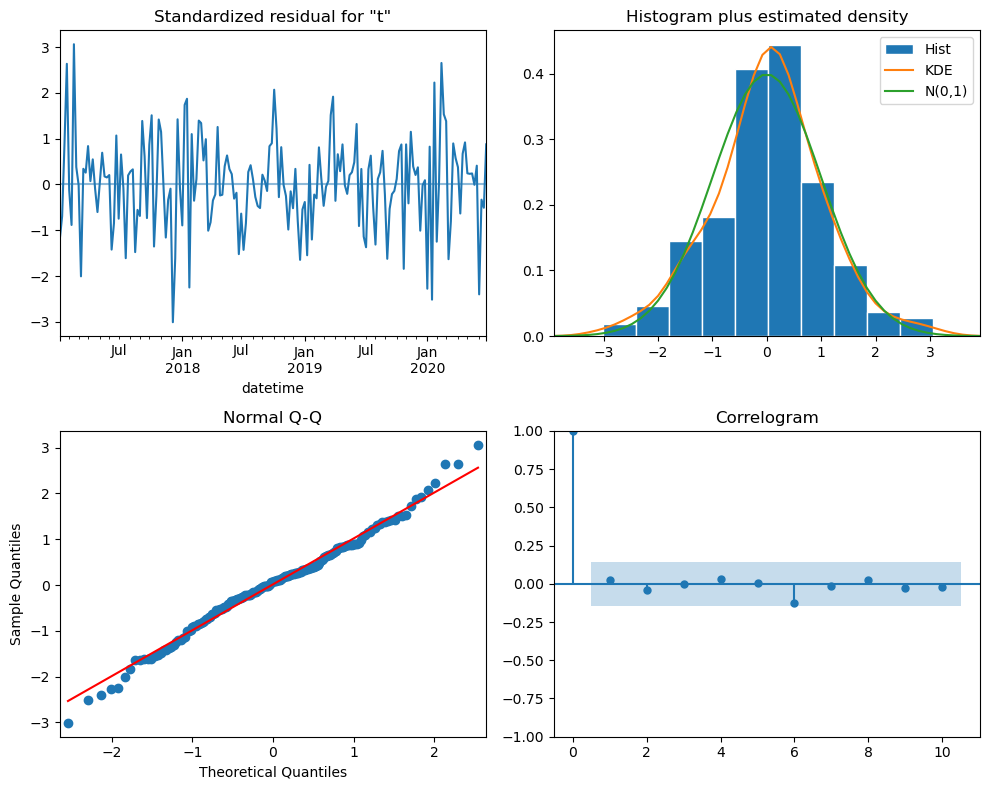

In [42]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_M.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [43]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_M.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.039177,0.843099
2,1.244285,0.536793
3,1.505314,0.681044
4,1.603003,0.808252
5,1.638657,0.896535
6,2.117370,0.908594
7,2.159995,0.950457
8,2.176524,0.975116
9,3.015219,0.963689
10,3.018692,0.980981


In [44]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.3366
Conclusion: Evidence of positive autocorrelation.


In [45]:
# Must match the structure of training exog
exog_test_M = test[['dew']] 

# Forecast the next Time points with exogenous inputs
forecast_M = model_fit_M.get_forecast(steps=test.shape[0], exog=exog_test_M)

# Extract predicted mean and confidence intervals
forecast_mean_M = forecast_M.predicted_mean
conf_int_M = forecast_M.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast M'] = forecast_mean_M.values
test['Error M'] = test['Forecast M'] - test['temp']
test['Lower 95% CI M'] = conf_int_M.iloc[:, 0].values
test['Upper 95% CI M'] = conf_int_M.iloc[:, 1].values

# Display updated test DataFrame
test.head()

,temp,dew,humidity,sealevelpressure,winddir,solarradiation,windspeed,precipprob,preciptype,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S,Forecast M,Error M,Lower 95% CI M,Upper 95% CI M
datetime,,,,,,,,,,,,,,,,,
2020-07-05,28.042857,26.000000,89.057143,1002.085714,197.914286,165.342857,24.942857,100.0,1.0,26.710386,-1.332471,24.465796,28.954976,28.473457,0.430599,26.358064,30.588849
2020-07-12,28.614286,26.357143,87.900000,1002.628571,204.242857,229.514286,27.457143,100.0,1.0,28.315304,-0.298982,25.968397,30.662212,29.234589,0.620304,26.952054,31.517125
2020-07-19,27.242857,26.014286,93.271429,1001.971429,169.157143,192.414286,23.200000,100.0,1.0,27.774671,0.531814,25.355089,30.194254,29.117440,1.874583,26.679196,31.555684
2020-07-26,28.857143,25.842857,84.257143,1005.257143,168.214286,186.742857,19.400000,100.0,1.0,28.171478,-0.685665,25.699676,30.643280,29.139319,0.282176,26.554733,31.723904
2020-08-02,27.785714,25.814286,89.471429,1004.400000,157.842857,194.842857,21.871429,100.0,1.0,26.559480,-1.226234,24.049870,29.069091,28.501188,0.715474,25.778118,31.224258


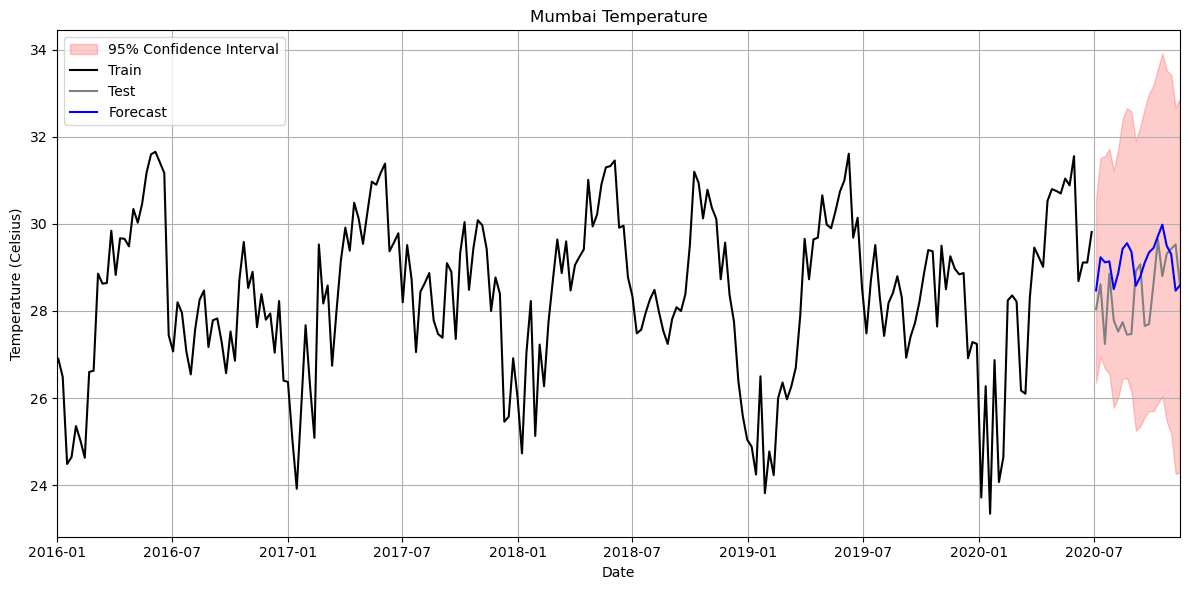

In [46]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_M.iloc[:, 0],     # Lower bound
                 conf_int_M.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['temp'], label='Train', color='black')           # Train
plt.plot(test.index, test['temp'], label='Test', color='gray')               # Test
plt.plot(test.index, test['Forecast M'], label='Forecast', color='blue')     # Forecast

plt.title('Mumbai Temperature')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (Celsius)')
plt.xlim(pd.to_datetime('2016-01-01'), pd.to_datetime('2020-11-15'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show();

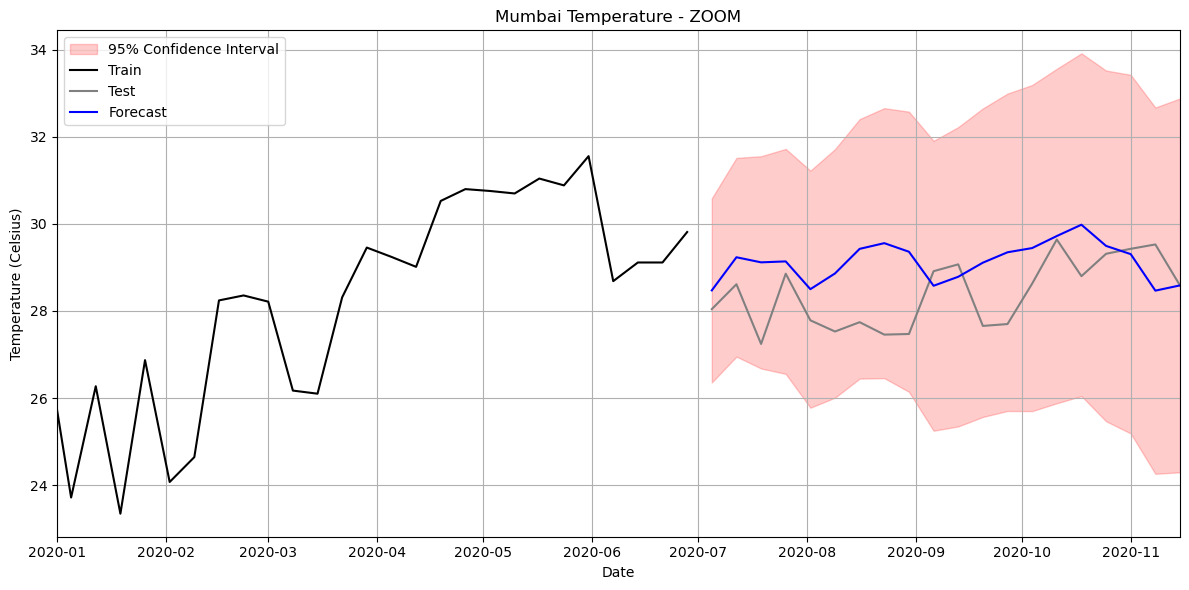

In [47]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_M.iloc[:, 0],     # Lower bound
                 conf_int_M.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['temp'], label='Train', color='black')           # Train
plt.plot(test.index, test['temp'], label='Test', color='gray')               # Test
plt.plot(test.index, test['Forecast M'], label='Forecast', color='blue')     # Forecast

plt.title('Mumbai Temperature - ZOOM')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (Celsius)')
plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2020-11-15'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show();

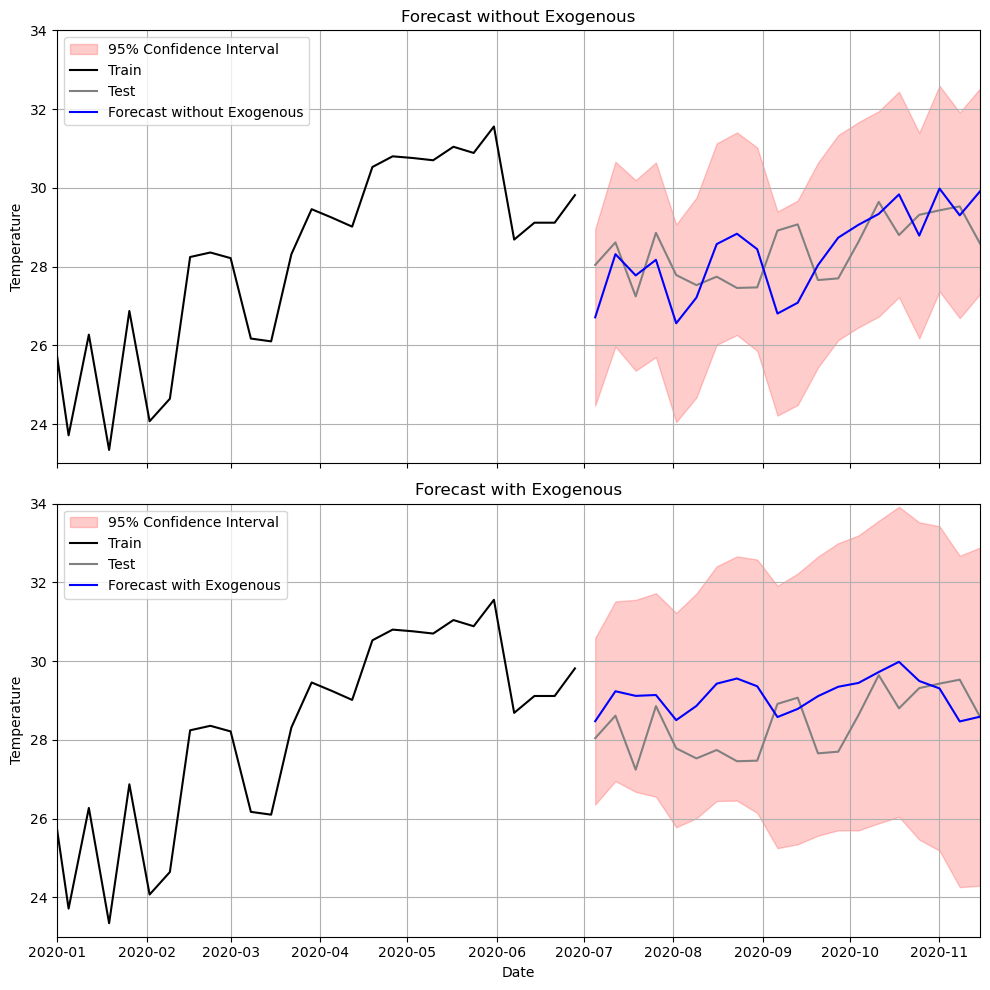

In [48]:
# Create subplots: 2 rows, 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# --- First Forecast (Forecast S) ---
axes[0].fill_between(test.index,
                     conf_int_S.iloc[:, 0],
                     conf_int_S.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[0].plot(train.index, train['temp'], label='Train', color='black')
axes[0].plot(test.index, test['temp'], label='Test', color='gray')
axes[0].plot(test.index, test['Forecast S'], label='Forecast without Exogenous', color='blue')

axes[0].set_title('Forecast without Exogenous')
axes[0].set_ylabel('Temperature')
axes[0].legend(loc=2)
axes[0].grid(True)
axes[0].set_xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2020-11-15'))
axes[0].set_ylim(23, 34)

# --- Second Forecast (Forecast M) ---
axes[1].fill_between(test.index,
                     conf_int_M.iloc[:, 0],
                     conf_int_M.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[1].plot(train.index, train['temp'], label='Train', color='black')
axes[1].plot(test.index, test['temp'], label='Test', color='gray')
axes[1].plot(test.index, test['Forecast M'], label='Forecast with Exogenous', color='blue')

axes[1].set_title('Forecast with Exogenous')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Temperature')
axes[1].legend(loc=2)
axes[1].grid(True)
axes[1].set_xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2020-11-15'))
axes[1].set_ylim(23, 34)

# Final layout
plt.tight_layout()
plt.show()

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Metrics for Forecast without Exo
mae_s = mean_absolute_error(test['temp'], test['Forecast S'])
rmse_s = np.sqrt(mean_squared_error(test['temp'], test['Forecast S']))
mape_s = mean_absolute_percentage_error(test['temp'], test['Forecast S']) * 100

# Metrics for Forecast with Exo
mae_m = mean_absolute_error(test['temp'], test['Forecast M'])
rmse_m = np.sqrt(mean_squared_error(test['temp'], test['Forecast M']))
mape_m = mean_absolute_percentage_error(test['temp'], test['Forecast M']) * 100

# Combine into dictionaries
metrics_S = {
    'MAE': mae_s,
    'RMSE': rmse_s,
    #'MAPE': mape_s,
}
metrics_M = {
    'MAE': mae_m,
    'RMSE': rmse_m,
    #'MAPE': mape_m,
}

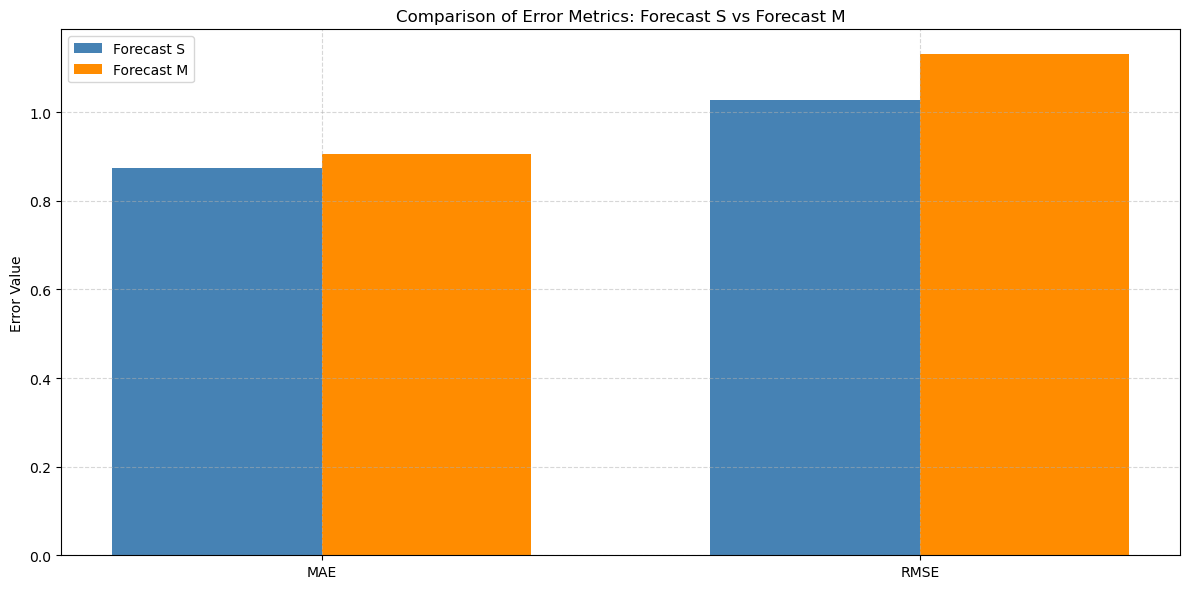

In [50]:
# Plotting
labels = list(metrics_S.keys())
values_S = list(metrics_S.values())
values_M = list(metrics_M.values())

x = range(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], values_S, width=width, label='Forecast S', color='steelblue')
plt.bar([i + width/2 for i in x], values_M, width=width, label='Forecast M', color='darkorange')

plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("Comparison of Error Metrics: Forecast S vs Forecast M")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [51]:
# Create DataFrame for Error Analysis
comparison_df = pd.DataFrame([metrics_S, metrics_M], index=['Forecast S', 'Forecast M']).T.round(2) 
comparison_df

,Forecast S,Forecast M
MAE,0.87,0.90
RMSE,1.03,1.13


In [52]:
from sklearn.metrics import mean_absolute_percentage_error

# MAPE
mape_s = mean_absolute_percentage_error(test['temp'], test['Forecast S']) * 100
mape_m = mean_absolute_percentage_error(test['temp'], test['Forecast M']) * 100

# Create DataFrame for Error Analysis
comparison_mape = pd.DataFrame([mape_s, mape_m], index=['MAPE S', 'MAPE M']).T.round(2) 
comparison_mape

,MAPE S,MAPE M
0,3.08,3.24


In [53]:
# Model without exogenous variable had better results
accuracy = 100 - mape_s

print(f"Model Accuracy (based on MAPE): {accuracy:.2f}%")

Model Accuracy (based on MAPE): 96.92%


End.